In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from sktime.classification.deep_learning.cnn import CNNClassifier
from sktime.classification.deep_learning.resnet import ResNetClassifier
from sktime.classification.deep_learning import InceptionTimeClassifier
from sktime.classification.kernel_based import RocketClassifier
from sktime.classification.hybrid import HIVECOTEV2


from sklearn.metrics import accuracy_score, cohen_kappa_score, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

import sys
sys.path.append('..')
# from slp_package.slp_functions import create_merged_game_data_df
from slp_package.input_dataset import InputDataSet

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2024-08-12 18:28:27.884220: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-12 18:28:27.906880: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-12 18:28:27.906899: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 18:28:27.907546: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-12 18:28:27.911296: I tensorflow/core/platform/cpu_feature_guar

Num GPUs Available:  1


2024-08-12 18:28:29.251117: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-12 18:28:29.254823: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-12 18:28:29.254898: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

<h2> Define functions </h2>
A function to asses the models we train.

In [2]:
def asses_model(model_name, y_pred, y_test, labels_order):
    print()
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_pred, y_test)

    # Print accuracy and Cohen Kappa score with explanations
    print(f'Accuracy of {model_name}: {accuracy:.4f}')
    print(f'Cohen Kappa Score of {model_name}: {kappa:.4f}')

    # Calculate the normalized predicted label count
    unique_pred, counts_pred = np.unique(y_pred, return_counts=True)
    unique_test, counts_test = np.unique(y_test, return_counts=True)
    normalized_counts_pred = {k: v / counts_test[np.where(unique_test == k)[0][0]] for k, v in zip(unique_pred, counts_pred)}
    
    # Calculate the percent the model over or under predicted the labels using the specified label order
    sorted_values = [normalized_counts_pred[k] - 1 if k in normalized_counts_pred else 0 for k in labels_order]

    # Plotting the percent the model over or under predicted the labels
    plt.figure(figsize=(2*len(labels_order)+10, 4))
    plt.bar(labels_order, sorted_values, color=['green' if x > 0 else 'blue' for x in sorted_values])
    plt.title(f'Percent Model {model_name} Over or Under Predicted Labels')
    plt.xlabel('Labels')
    plt.ylabel('Percent Over/Under Prediction')
    
    # Center y-axis and set equal extension above and below
    max_extent = max(abs(min(sorted_values)), abs(max(sorted_values))) * 1.05
    plt.ylim(-max_extent, max_extent)
    plt.axhline(y=0, color='gray', linewidth=0.8)
    plt.show()

    # Display each confusion matrix on its own row
    for norm in [None, 'true', 'pred']:
        plt.figure(figsize=(len(labels_order)+4, len(labels_order)+4))
        ax = plt.gca()
        ConfusionMatrixDisplay.from_predictions(
            y_test, y_pred, normalize=norm, ax=ax,
            xticks_rotation='vertical', labels=labels_order
        )
        ax.title.set_text(f'{model_name} Confusion Matrix ({"Not Normalized" if norm is None else "Normalized by " + norm})')
        plt.tight_layout()
        plt.show()
    

<h2> Define Features </h2>
Here we define the parameters for the InputDataSet object we will create. It includes the source of the data we want and a list of features we will restrict ourselves to.

In [3]:
# We classify 5 characters on competitive stages

source_data = ['public','ranked','mango']

general_features = {
    'stage_name': ['FOUNTAIN_OF_DREAMS','FINAL_DESTINATION','BATTLEFIELD','YOSHIS_STORY','POKEMON_STADIUM','DREAMLAND'],
    'num_players': [2],
    'conclusive': [True]
}
player_features = {
    # 'netplay_code': ['MANG#0'],
    # 'character_name': ['FOX', 'FALCO', 'MARTH', 'CAPTAIN_FALCON', 'SHEIK'],
    'character_name': ['PIKACHU','PICHU'],
    # 'character_name': ['FOX', 'CAPTAIN_FALCON', 'SHEIK', 'FALCO', 'GAME_AND_WATCH', 'MARTH', 'LINK', 'ICE_CLIMBERS', 'SAMUS', 'GANONDORF', 'BOWSER', 'MEWTWO', 'YOSHI', 'PIKACHU', 'JIGGLYPUFF', 'NESS', 'DR_MARIO', 'PEACH', 'LUIGI', 'DONKEY_KONG'],
    'type_name': ['HUMAN']
    
}
opposing_player_features = {
    # 'character_name': ['MARTH'],
    # 'netplay_code': ['KOD#0', 'ZAIN#0']
    'type_name': ['HUMAN']
}
label_info = {
    'source': ['player'], # Can be 'general', 'player
    # 'feature': ['netplay_code']
    'feature': ['character_name']
}
    

<h2> Create Dataset Object </h2>
We create the dataset object and check the number of games for each label in our data and print the first several rows of the dataset to make sure it looks correct.

In [4]:
dataset = InputDataSet(source_data, general_features, player_features, opposing_player_features, label_info)

print(dataset.dataset['labels'].value_counts())
# print(list(dataset.dataset['labels'].unique()))
# dataset.dataset.head()

PIKACHU    4096
PICHU       230
Name: labels, dtype: int64


/workspace/slp_jaspar/slp/sktime_baseline_tests/../slp_package/input_dataset.py:95: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  processed_df = pd.concat([player_1_df, player_2_df], ignore_index=True)


<h2> Call number_of_segments_per_game() </h2>
We set the length of the segments and the number of segments per label that we want in the dataset we are going to prepare. In the column 'Count' we see the number of games we have for each label (this is less than the value counts earlier because we discard games that are too short). In the column 'Shift' we see how much each segment will be shifted by. If the shift is less than the length of the segments, the data we prepare will contain overlaping segments.

In [5]:
labels_order =  dataset.number_of_segments_per_game(3600,1000)
print(labels_order)
labels_order = labels_order['Label'].values


     Label  Count  Shift
0  PIKACHU   4067  30486
1    PICHU    227   1648


<h2> Split data and prepare it for the model </h2>

In [6]:
X_train, X_test, y_train, y_test  = dataset.train_test_split_numpy(test_ratio = .20, val = False)
print()
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

100%|██████████| 837/837 [00:00<00:00, 4609.04it/s]



(1600, 9, 3600)
(1600,)
(400, 9, 3600)
(400,)


<h2> Train sktime model </h2>
Now that we have prepared our dataset, we train a model with sktime. After we train the model we calculate its score on the test data.

In [7]:
# batch_size = 16
# epochs = 30
# # epochs = 15
# model_name = 'ResNetClassifier'
# # import keras
# # from keras.metrics import 
# # 
# resnet_model = ResNetClassifier(verbose = 1, n_epochs=epochs, batch_size=batch_size, loss = 'categorical_crossentropy', random_state=42, optimizer='Adam') #Cohen Kappa Score of ResNetClassifier: 0.8340
# # resnet_model = ResNetClassifier(verbose = 1, n_epochs=epochs, batch_size=batch_size, loss = 'categorical_crossentropy', random_state=42, optimizer='Adamax') #Cohen Kappa Score of ResNetClassifier: 0.7940

# resnet_model.fit(X_train, y_train)

# y_pred = resnet_model.predict(X_test)
# asses_model(model_name, y_pred, y_test,labels_order)
# tf.compat.v1.reset_default_graph()

In [8]:
# import gc
# gc.collect()


In [9]:
# y_pred = resnet_model.predict(X_test)
# asses_model(model_name, y_pred, y_test,labels_order)

In [10]:
# batch_size = 16
# epochs = 30
# model_name = 'InceptionTimeClassifier'

# inceptiontime_model = InceptionTimeClassifier(n_epochs=epochs, batch_size=batch_size,  random_state=42, verbose=True, loss='categorical_crossentropy')
# inceptiontime_model.fit(X_train, y_train) 
# y_pred = inceptiontime_model.predict(X_test) 
# asses_model(model_name, y_pred, y_test,labels_order)
# tf.compat.v1.reset_default_graph()


Accuracy of MiniRocketClassifier: 0.9275
Cohen Kappa Score of MiniRocketClassifier: 0.8550


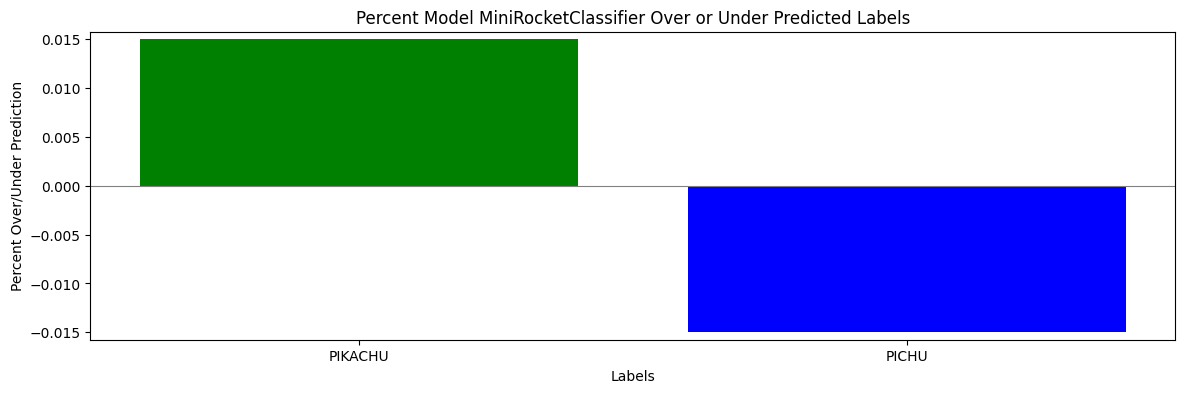

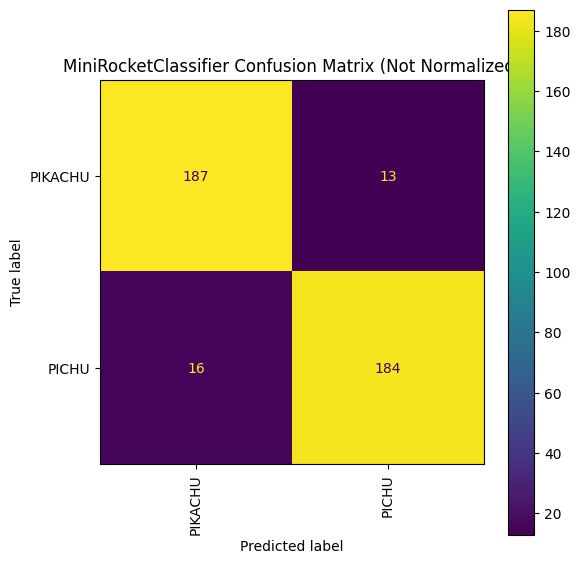

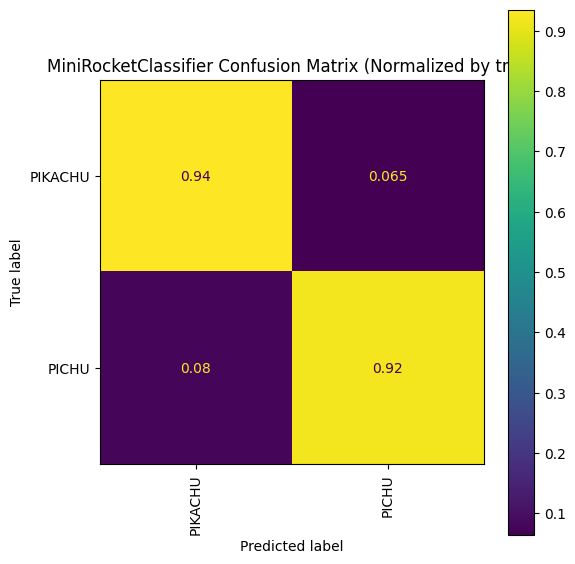

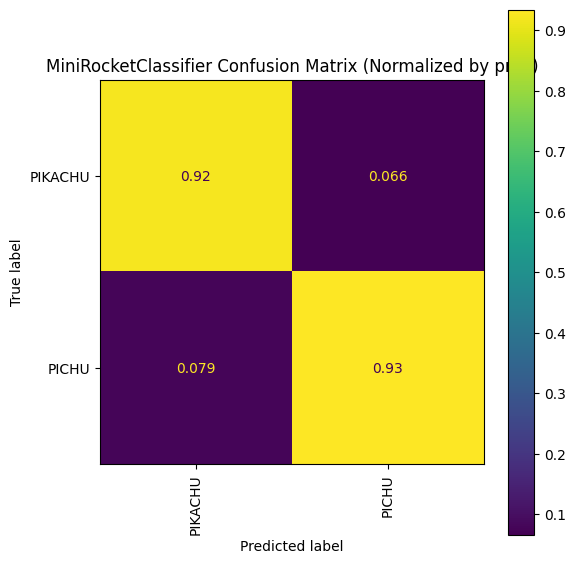

In [11]:
model_name = 'MiniRocketClassifier'
rocket_model = RocketClassifier(n_jobs=-1, random_state=42, rocket_transform = 'minirocket') 
rocket_model.fit(X_train, y_train) 
y_pred = rocket_model.predict(X_test) 
asses_model(model_name, y_pred, y_test,labels_order)


Accuracy of MiniRocketClassifier: 0.9250
Cohen Kappa Score of MiniRocketClassifier: 0.8500


/tmp/ipykernel_57333/3563895354.py:28: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(-max_extent, max_extent)


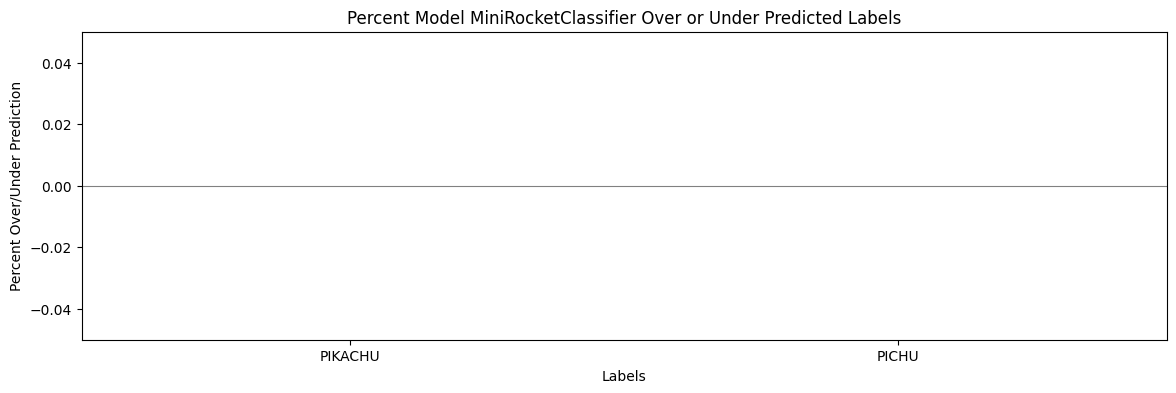

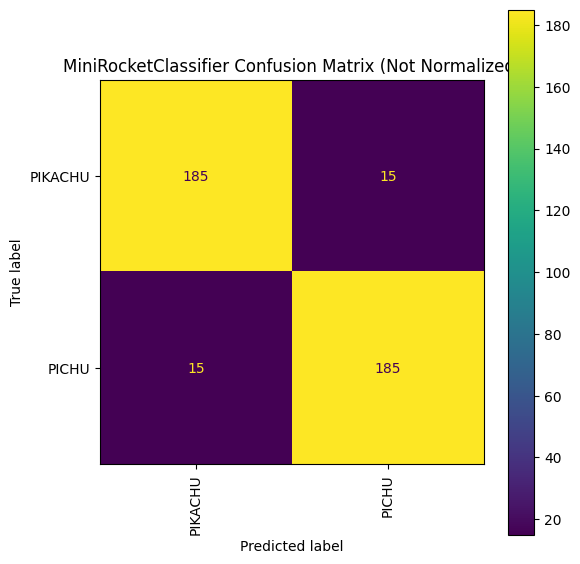

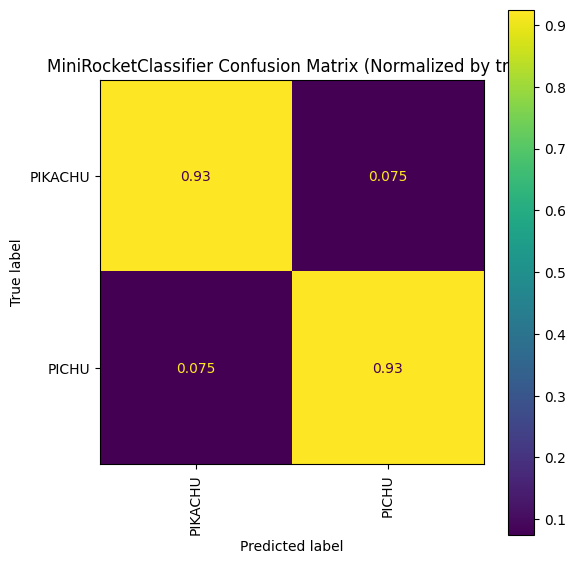

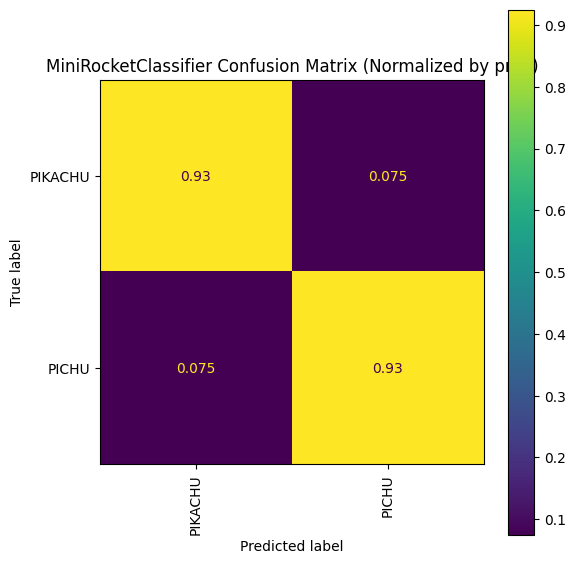

In [30]:
model_name = 'MiniRocketClassifier'
rocket_model = RocketClassifier(num_kernels=2000, n_jobs=-1, random_state=42, rocket_transform = 'minirocket') 
rocket_model.fit(X_train, y_train) 
y_pred = rocket_model.predict(X_test) 
asses_model(model_name, y_pred, y_test,labels_order)


Accuracy of MiniRocketClassifier: 0.9400
Cohen Kappa Score of MiniRocketClassifier: 0.8800


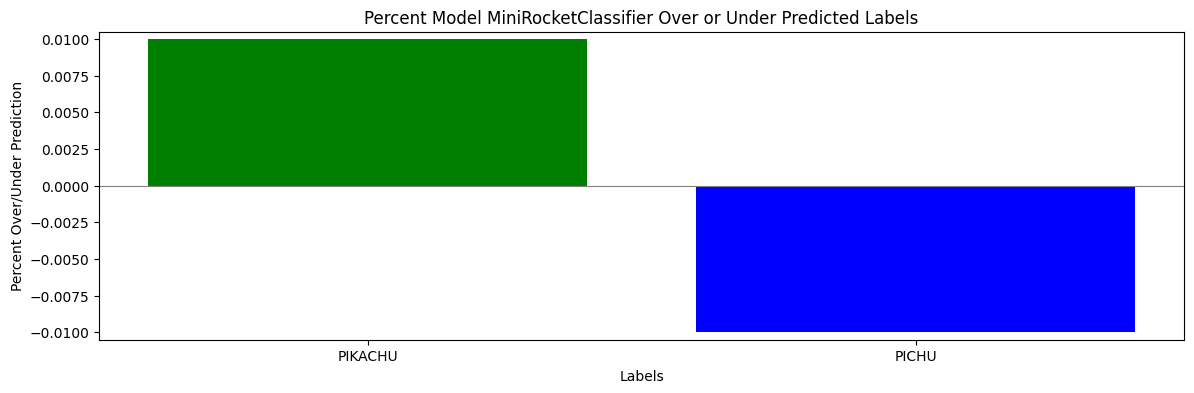

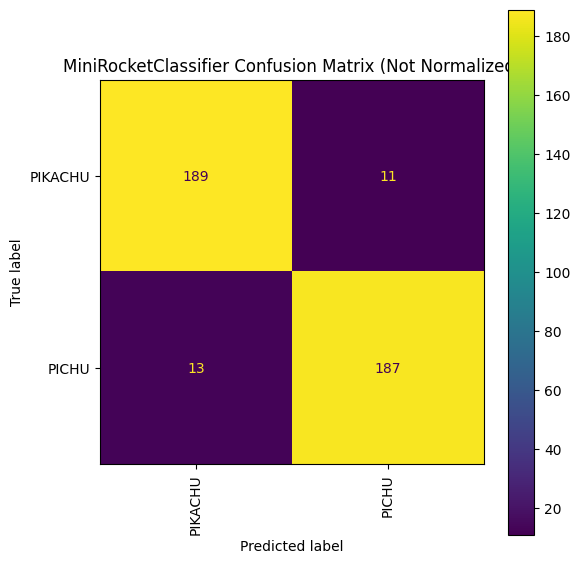

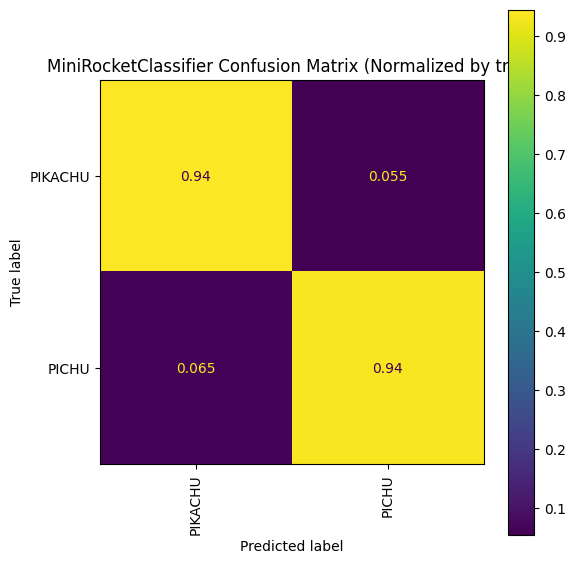

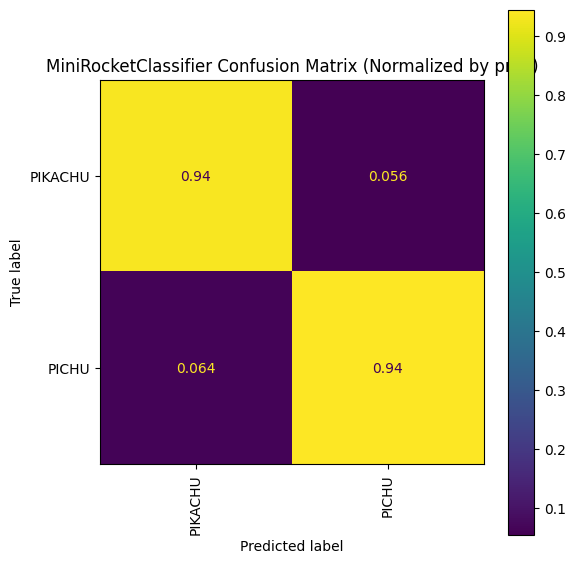

In [31]:
model_name = 'MiniRocketClassifier'
rocket_model = RocketClassifier(num_kernels=32000, n_jobs=-1, random_state=42, rocket_transform = 'minirocket') 
rocket_model.fit(X_train, y_train) 
y_pred = rocket_model.predict(X_test) 
asses_model(model_name, y_pred, y_test,labels_order)


Accuracy of MiniRocketClassifier: 0.9400
Cohen Kappa Score of MiniRocketClassifier: 0.8800


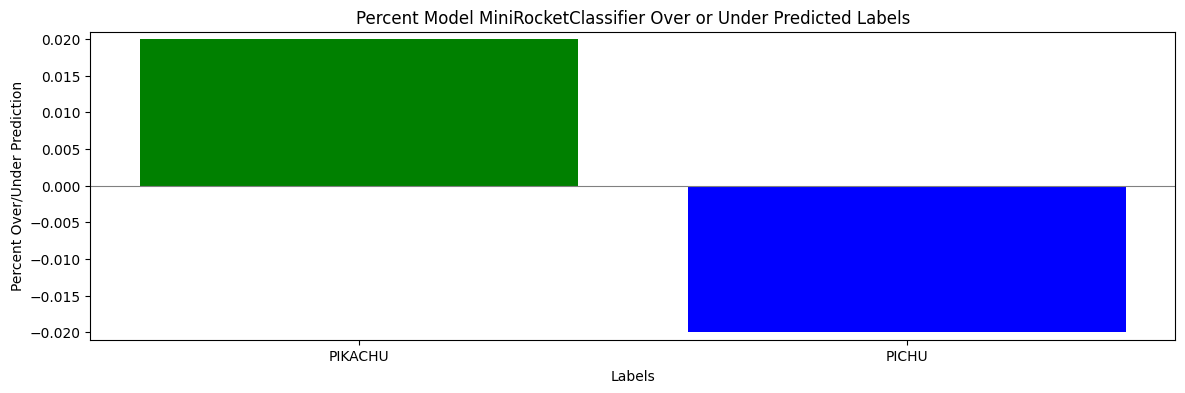

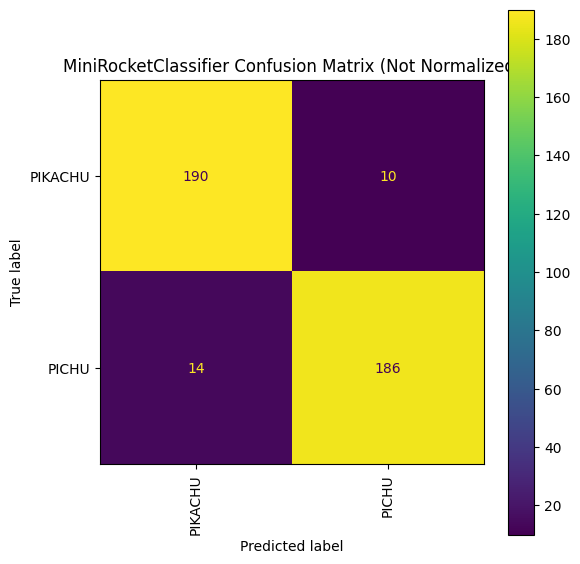

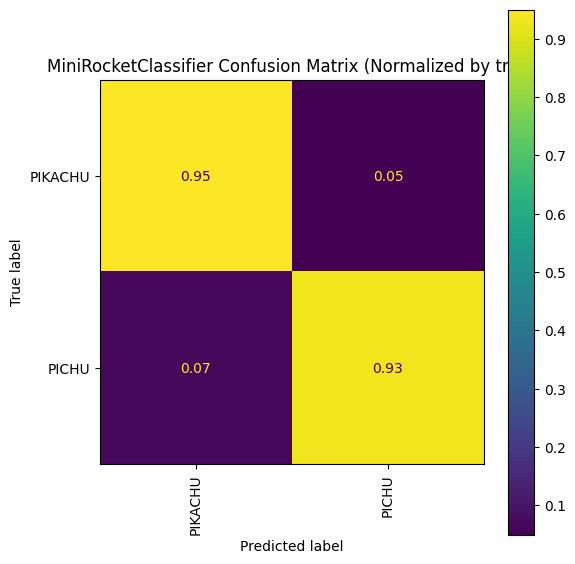

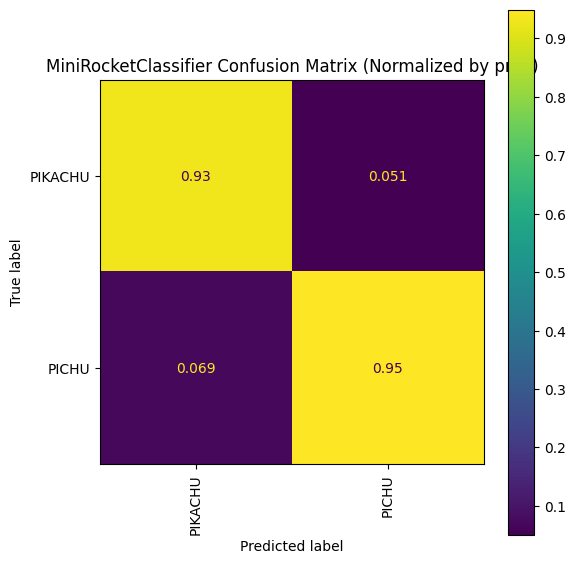

In [32]:
model_name = 'MiniRocketClassifier'
rocket_model = RocketClassifier(num_kernels=128000, n_jobs=-1, random_state=42, rocket_transform = 'minirocket') 
rocket_model.fit(X_train, y_train) 
y_pred = rocket_model.predict(X_test) 
asses_model(model_name, y_pred, y_test,labels_order)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 3600, 9)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 3600, 32)             288       ['input_5[0][0]']             
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 3600, 9)              0         ['input_5[0][0]']             
 D)                                                                                               
                                                                                                  
 conv1d_1 (Conv1D)           (None, 3600, 16)             10240     ['conv1d[0][0]']          

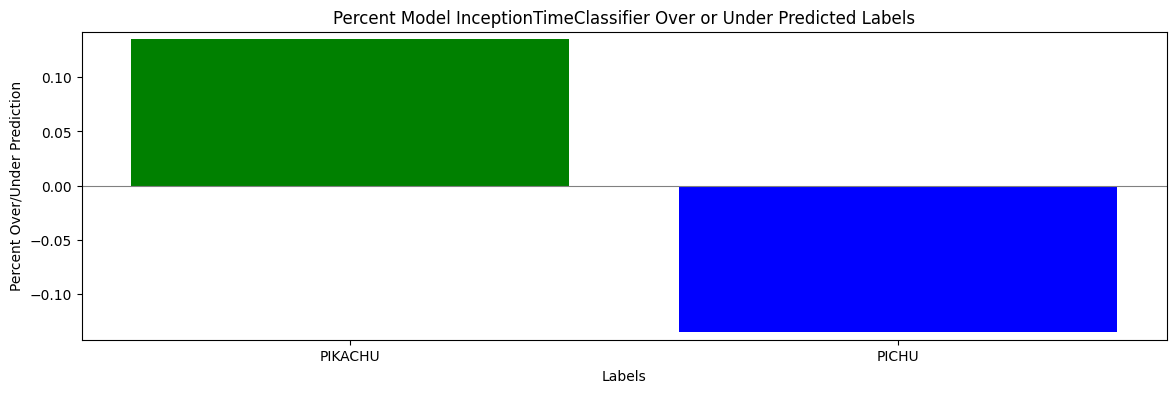

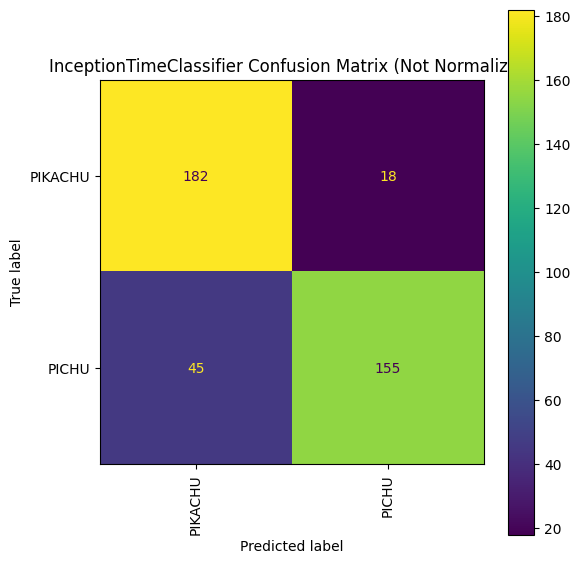

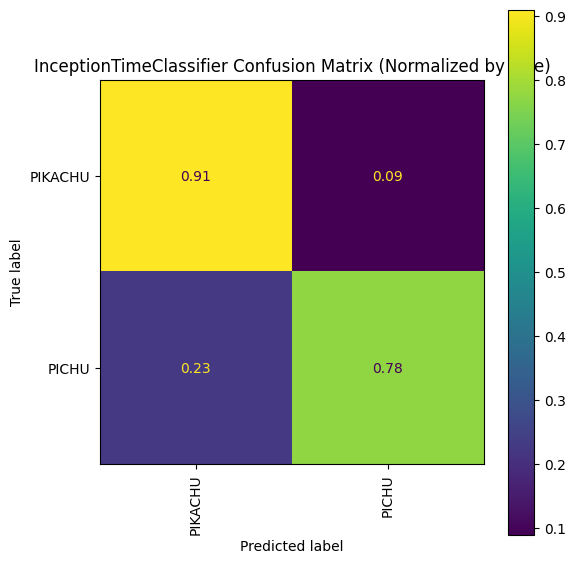

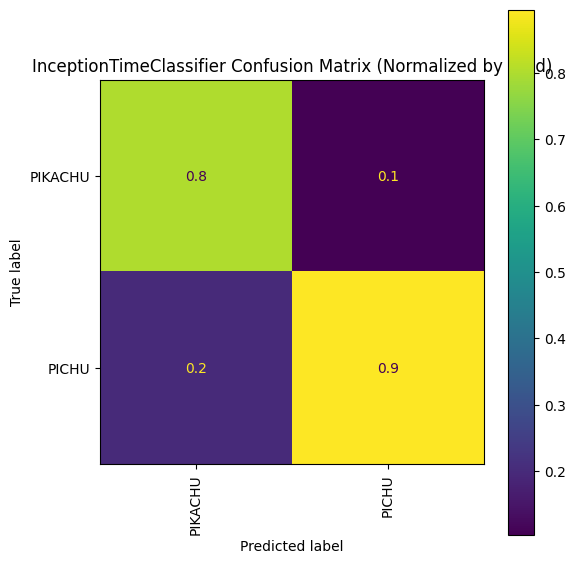

In [28]:
# epochs = 30  # You might want to increase this gradually to find the sweet spot
# batch_size = 32  # A smaller batch size than the default to help with generalization
# kernel_size = 20  # Smaller than default, assuming it still captures relevant features in your data
# n_filters = 16  # Fewer filters to reduce model complexity
# depth = 4  # Reduced depth to simplify the model

# inceptiontime_model = InceptionTimeClassifier(
#     n_epochs=epochs,
#     batch_size=batch_size,
#     kernel_size=kernel_size,
#     n_filters=n_filters,
#     use_residual=True,  # Keep using residual connections, but this can be toggled for experimentation
#     use_bottleneck=True,  # Keep the bottleneck, but consider adjusting the size if overfitting persists
#     bottleneck_size=32,  # You might want to reduce this if the model is still overfitting
#     depth=depth,
#     random_state=42,
#     verbose=True,
#     loss='categorical_crossentropy'
# )

# inceptiontime_model.fit(X_train, y_train) 
# y_pred = inceptiontime_model.predict(X_test) 
# asses_model(model_name, y_pred, y_test, labels_order)
# tf.compat.v1.reset_default_graph()
